In [53]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
import torchvision.transforms as transforms
import torchvision.models as models
import copy
import matplotlib.pyplot as plt
import numpy as np
import requests
import zipfile
from io import BytesIO
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

loader = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor()
])

unloader = transforms.ToPILImage()

def image_loader(image_path):
    image = Image.open(image_path).convert('RGB')
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

Using device: cuda


In [64]:
style_image_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/1280px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg"
try:
        response = requests.get(style_image_url)
        style_img = loader(Image.open(BytesIO(response.content)).convert('RGB')).unsqueeze(0).to(device, torch.float)
        print("Van Gogh style image downloaded from Wikimedia Commons")
except Exception as e:
        print(f"Error downloading from Wikimedia: {e}")
        print("Using random noise as placeholder style image")
        style_img = torch.randn(1, 3, 512, 512, device=device)


Van Gogh style image downloaded from Wikimedia Commons


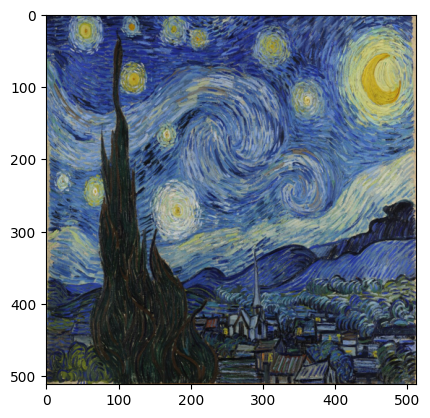

In [65]:
imshow(style_img)

In [69]:
content_image_url = "https://img.freepik.com/premium-photo/closeup-portrait-gray-striped-domestic-catimage-veterinary-clinics-sites-about-cats-cat-food_141438-3922.jpg?w=360"
try:
        response = requests.get(content_image_url)
        content_img = loader(Image.open(BytesIO(response.content)).convert('RGB')).unsqueeze(0).to(device, torch.float)
        print("Content image downloaded from Wikimedia Commons")
except Exception as e:
        print(f"Error downloading from Wikimedia: {e}")
        # Create a placeholder as last resort
        print("Using random noise as placeholder style image")
        content_img = torch.randn(1, 3, 512, 512, device=device)


Content image downloaded from Wikimedia Commons


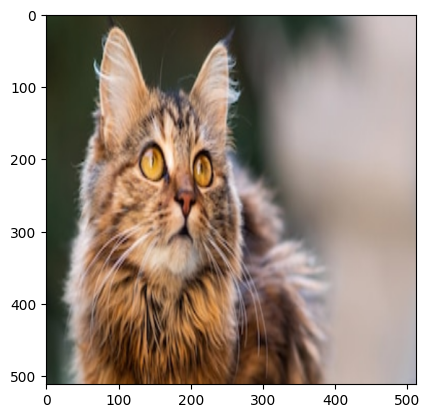

In [70]:
imshow(content_img)

<Figure size 640x480 with 0 Axes>

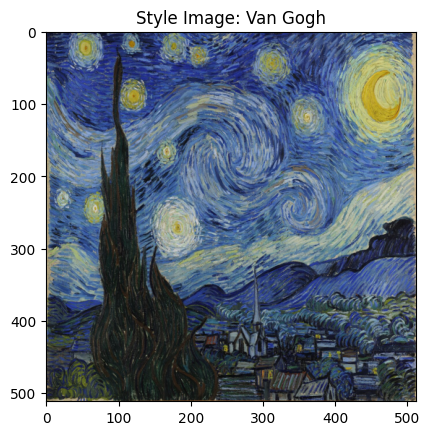

<Figure size 640x480 with 0 Axes>

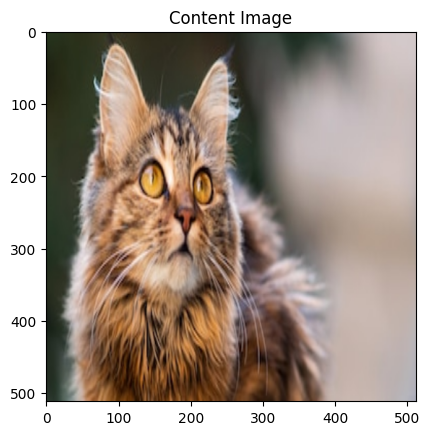

In [71]:
plt.figure()
imshow(style_img, title='Style Image: Van Gogh')
plt.figure()
imshow(content_img, title='Content Image: A Cat')

In [79]:
st_sc=[]
ct_sc=[]

class ContentLoss(nn.Module):
    def __init__(self, target):
        super(ContentLoss, self).__init__()
        self.target = target.detach()
        self.loss = F.mse_loss(self.target, self.target)

    def forward(self, x):
        self.loss = F.mse_loss(x, self.target)
        return x

def gram_matrix(input):
    batch_size, n_channels, height, width = input.size()
    features = input.view(batch_size * n_channels, height * width)
    G = torch.mm(features, features.t())
    return G.div(batch_size * n_channels * height * width)

class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()
        self.loss = F.mse_loss(self.target, self.target)

    def forward(self, x):
        G = gram_matrix(x)
        self.loss = F.mse_loss(G, self.target)
        return x

class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = torch.tensor(mean).view(-1, 1, 1).to(device)
        self.std = torch.tensor(std).view(-1, 1, 1).to(device)

    def forward(self, img):
        return (img - self.mean) / self.std

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img, content_layers,
                               style_layers):
    normalization = Normalization(normalization_mean, normalization_std).to(device)
    content_losses = []
    style_losses = []
    model = nn.Sequential(normalization)
    i = 0
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = f'conv_{i}'
        elif isinstance(layer, nn.ReLU):
            name = f'relu_{i}'
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = f'pool_{i}'
        elif isinstance(layer, nn.BatchNorm2d):
            name = f'bn_{i}'
        else:
            raise RuntimeError(f'Unrecognized layer: {layer.__class__.__name__}')
        model.add_module(name, layer)
        if name in content_layers:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module(f'content_loss_{i}', content_loss)
            content_losses.append(content_loss)
        if name in style_layers:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module(f'style_loss_{i}', style_loss)
            style_losses.append(style_loss)
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break
    model = model[:(i + 1)]
    return model, style_losses, content_losses

def get_input_optimizer(input_img):
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1):
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img,
        content_layers=['conv_4'], style_layers=['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5'])
    optimizer = get_input_optimizer(input_img)
    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:
        def closure():
            input_img.data.clamp_(0, 1)
            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0
            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss
            style_score *= style_weight
            content_score *= content_weight
            loss = style_score + content_score
            loss.backward()
            run[0] += 1
            if run[0] % 50 == 0:
                print(f"run {run[0]}:")
                st_sc.append(style_score.item())
                ct_sc.append(content_score.item())
                print(f'Style Loss : {style_score.item():4f} Content Loss: {content_score.item():4f}')
                print()
            return style_score + content_score
        optimizer.step(closure)
    input_img.data.clamp_(0, 1)
    return input_img

def imshow(tensor, title=None):
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    image = unloader(image)
    plt.figure()
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)


In [80]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)
input_img = content_img.clone()
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img,num_steps=700)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Building the style transfer model..
Optimizing..


<ipython-input-79-6672c197931b>:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1).to(device)
<ipython-input-79-6672c197931b>:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1).to(device)


run 50:
Style Loss : 59.093021 Content Loss: 27.027061

run 100:
Style Loss : 18.030901 Content Loss: 25.303413

run 150:
Style Loss : 10.357342 Content Loss: 22.562336

run 200:
Style Loss : 6.067895 Content Loss: 20.431637

run 250:
Style Loss : 3.551754 Content Loss: 18.871784

run 300:
Style Loss : 2.189421 Content Loss: 17.758232

run 350:
Style Loss : 1.475063 Content Loss: 16.914618

run 400:
Style Loss : 1.075431 Content Loss: 16.346333

run 450:
Style Loss : 0.856200 Content Loss: 15.923732

run 500:
Style Loss : 0.719983 Content Loss: 15.599961

run 550:
Style Loss : 0.650221 Content Loss: 15.353165

run 600:
Style Loss : 0.602340 Content Loss: 15.173261

run 650:
Style Loss : 0.585843 Content Loss: 15.024113

run 700:
Style Loss : 0.567838 Content Loss: 14.931074



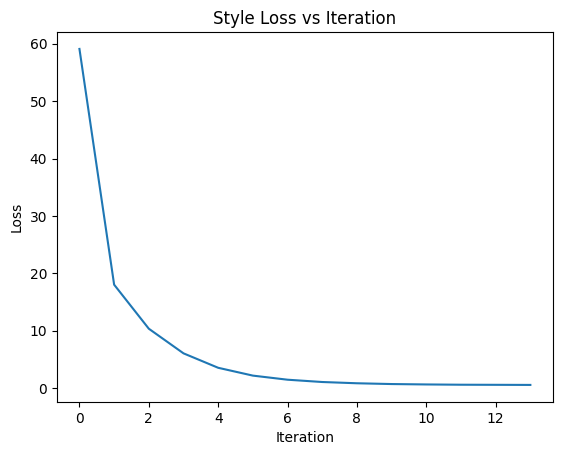

In [84]:
plt.plot(st_sc, label='Style Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Style Loss vs Iteration')
plt.show()


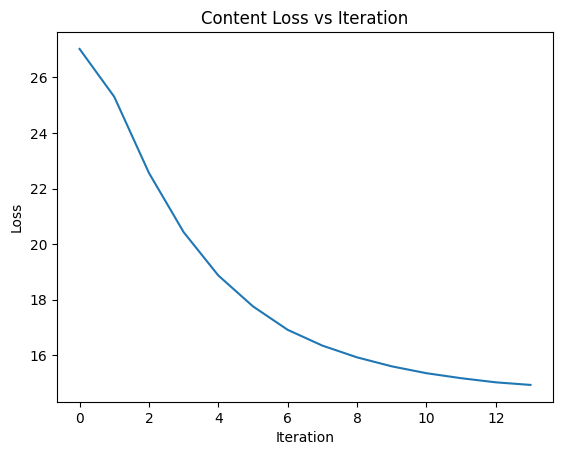

In [85]:
plt.plot(ct_sc, label='Content Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Content Loss vs Iteration')
plt.show()


<Figure size 640x480 with 0 Axes>

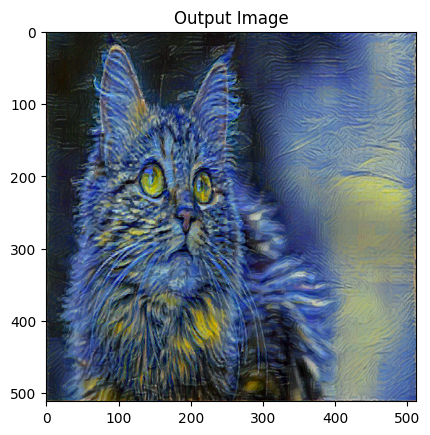

In [86]:
plt.figure()
imshow(output, title='Output Image')
plt.ioff()
plt.show()